In [279]:
import numpy as np
import pandas as pd
from cmdstanpy import cmdstan_path, CmdStanModel
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import statsmodels.api as sm
from psis import psisloo
from model_testing import create_lags
import diagnostics

from datamodel import SPX, StockData

plt.rcParams["figure.figsize"] = (15,10)

In [2]:
spx = SPX()
vix_data = StockData(["^VIX"])

In [44]:
spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()
vix_wk_prices = vix_data.prices.VIX["close"].resample("W-FRI").last()
spx_wk_vol = spx.vol.resample("W-FRI").sum()

wk_vix_lags = create_lags(vix_wk_prices, 4, "wk_vix")
wk_vol_lags = create_lags(spx_wk_vol, 4, "wk_vol")

x = pd.concat([np.log(np.square(wk_vix_lags / (100 * np.sqrt(52)))), np.log(wk_vol_lags)], axis=1).dropna()

common_index = x.index.intersection(y.index)
x = x.loc[common_index]
y = spx_wk_returns.loc[common_index]

# Model 1

In [90]:
model_spec = """
    data {
        int N;                              // Length of data
        int M;                              // Exogenous regressors dimensions
        vector[N] r;                        // SPX returns
        matrix[N, M] x;                     // Exogenous regressors data
    }
    parameters {
        real mu_h;                          // Volatility mean term
        real mu_r;                          // Returns mean term
        vector[M] beta;                     // Exogenous regressors coefficients
        real<lower=0> sigma;                // Volatility noise
        vector[N] h_std;                    // Log volatility
    }
    transformed parameters {
        vector[N] h = h_std * sigma;        // h ~ normal(0, sigma);
        for (t in 1:N) {
            h[t] += mu_h + x[t] * beta;     // h ~ normal(mu_h + x * beta, sigma)
        }
    }
    model {
        beta ~ normal(0, 10);
        sigma ~ normal(0, 10);
        mu_h ~ normal(0, 10);
        mu_r ~ normal(0, 10);
        
        h_std ~ std_normal();
        r ~ normal(mu_r, exp(h / 2));
    }
    generated quantities {
        real r_tilde[N];
        real log_prob[N];
        r_tilde = normal_rng(mu_r, exp(h / 2));
        for (t in 1:N) {
            log_prob[t] = normal_lpdf(r[t] | mu_r, exp(h[t] / 2));  // Need log probabilities later on
        }
    }
"""
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model


In [91]:
data = {"N": len(y),
        "M": len(x.columns),
        "r": y.values,
        "x": x.values}
sample = model.sample(data=data,
                      chains=4,
                      parallel_chains=4,
                      output_dir="./stan_model",
                      iter_warmup=1000,
                      iter_sampling=2500,
                      show_progress=True)

Chain 1 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                                                                                                                                    | 0/3500 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                                    | 0/3500 [00:00<?, ?it/s]


Chain 4 

Chain 1 - sample:  29%|███████████████████████████████████████▏                                                                                                 | 1000/3500 [00:54<01:50, 22.67it/s]


Chain 4 - warmup:  29%|███████████████████████████████████████▏                                                                                                 | 1000/3500 [00:55<01:56, 21.53it/s]


Chain 4 - sample:  29%|███████████████████████████████████████▏                                                                                                 | 1000/3500 [00:55<01:56, 21.53it/s]

Chain 1 - sample:  31%|███████████████████████████████████████████                                                                                              | 1100/3500 [01:02<02:08, 18.63it/s]


Chain 4 - sample:  31%|███████████████████████████████████████████                                                                                              | 1100/3500 [01:02<02:13, 18.01it/s]

Chain 1

Chain 1 - sample:  66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 2300/3500 [02:32<01:28, 13.54it/s]


Chain 2 - sample:  69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2400/3500 [02:37<01:22, 13.31it/s]

Chain 1 - sample:  69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2400/3500 [02:40<01:23, 13.11it/s]


Chain 2 - sample:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2500/3500 [02:46<01:19, 12.65it/s]

Chain 1 - sample:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2500/3500 [02:49<01:20, 12.48it/s]


Chain 2

Chain 4 -   done: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [04:10<00:00, 13.99it/s]


In [92]:
model1_data = az.from_cmdstanpy(posterior=sample,
                                posterior_predictive="r_tilde",
                                observed_data={"r": y.values},
                                log_likelihood="log_prob")

array([[<AxesSubplot:title={'center':'mu_h'}>,
        <AxesSubplot:title={'center':'mu_h'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

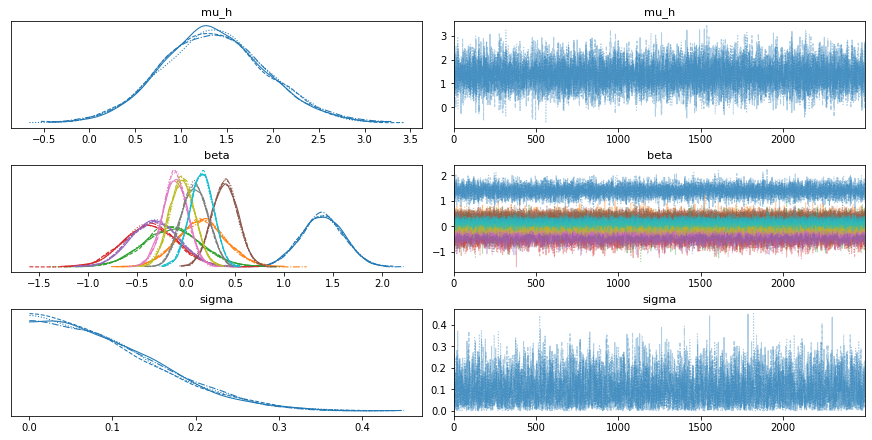

In [93]:
az.plot_trace(model1_data, compact=True, var_names=["mu_h", "beta", "sigma"])

Text(0.5, 1.0, 'Kurtosis')

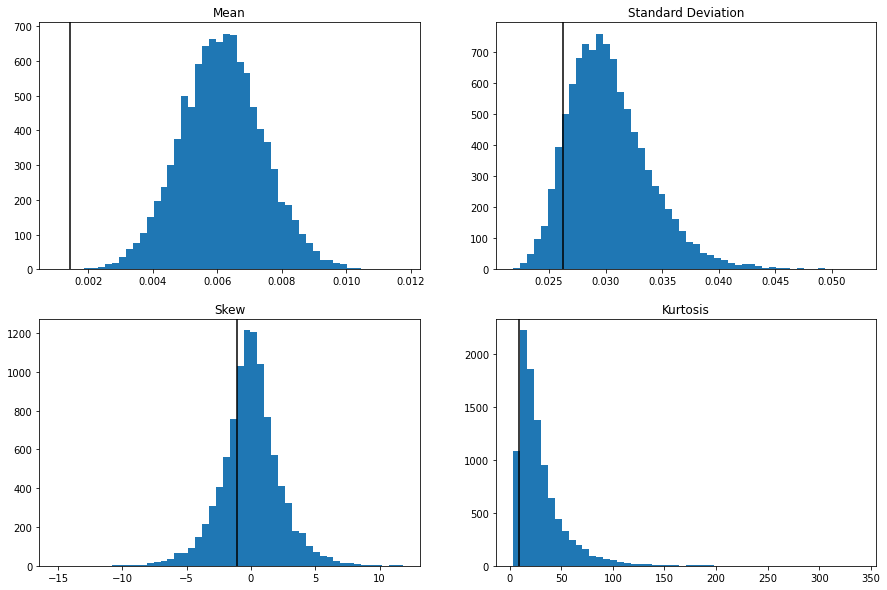

In [95]:
diagnost

<AxesSubplot:xlabel='r / r_tilde'>

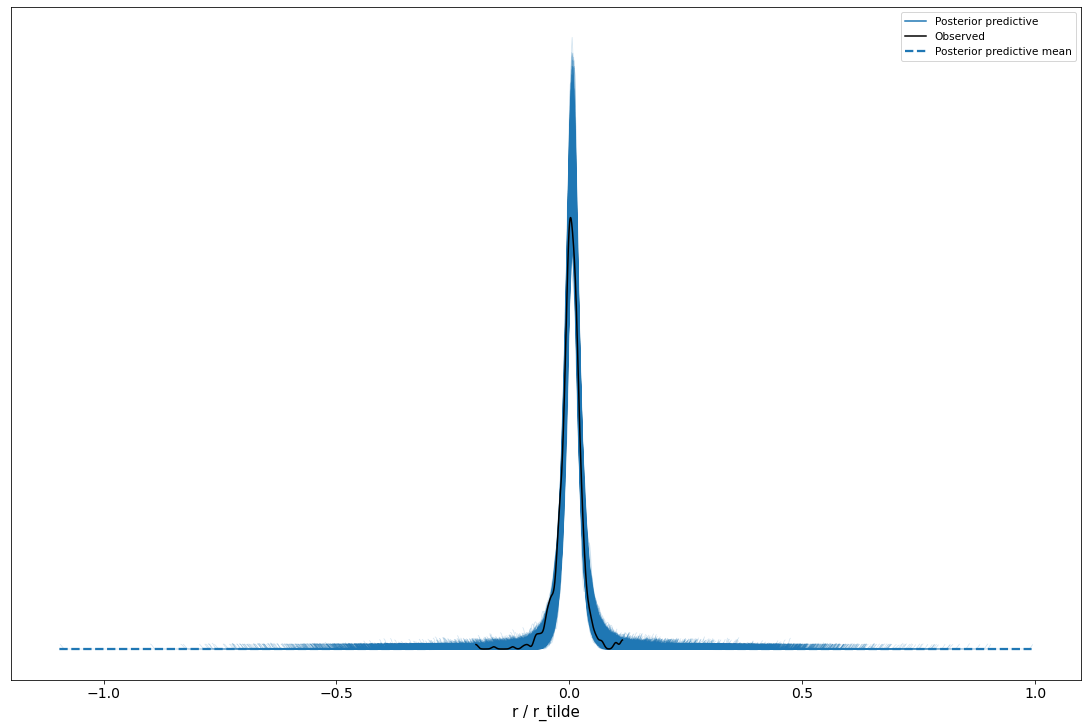

In [96]:
az.plot_ppc(model1_data, data_pairs={"r": "r_tilde"})

In [97]:
# 95% bounds exceedences
np.sum(y.values > np.percentile(r_tilde, 95, axis=0)) / len(y)

0.04607046070460705

In [242]:
# 5% bounds exceedences
np.sum(y.values < np.percentile(r_tilde, 5, axis=0)) / len(y)

0.028455284552845527

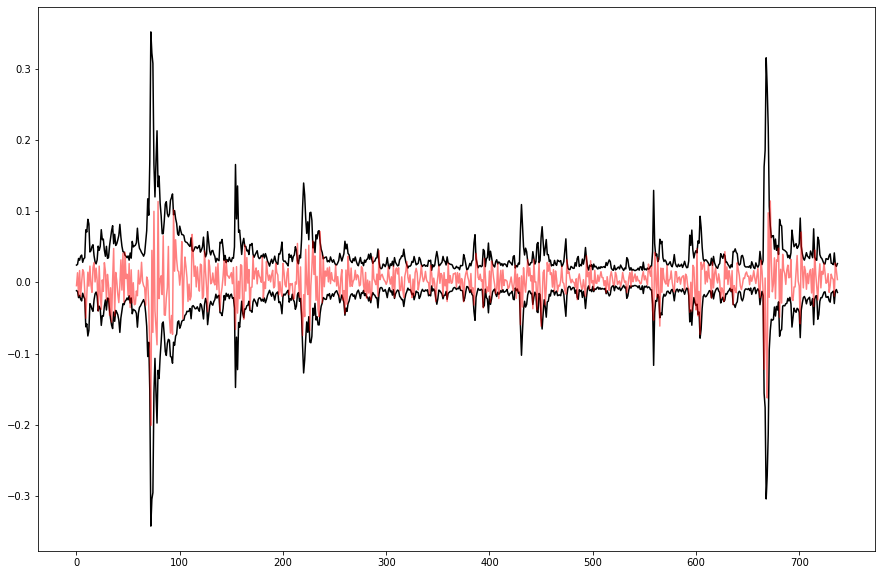

In [99]:
plt.plot(np.percentile(r_tilde, 95, axis=0), color="black")
plt.plot(np.percentile(r_tilde, 5, axis=0), color="black")
plt.plot(y.values, color="red", alpha=0.5)

In [100]:
values = []

for t in range(len(y)):
    ecdf = sm.distributions.empirical_distribution.ECDF(r_tilde[:, t])
    values.append(ecdf(y.iloc[t]))

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


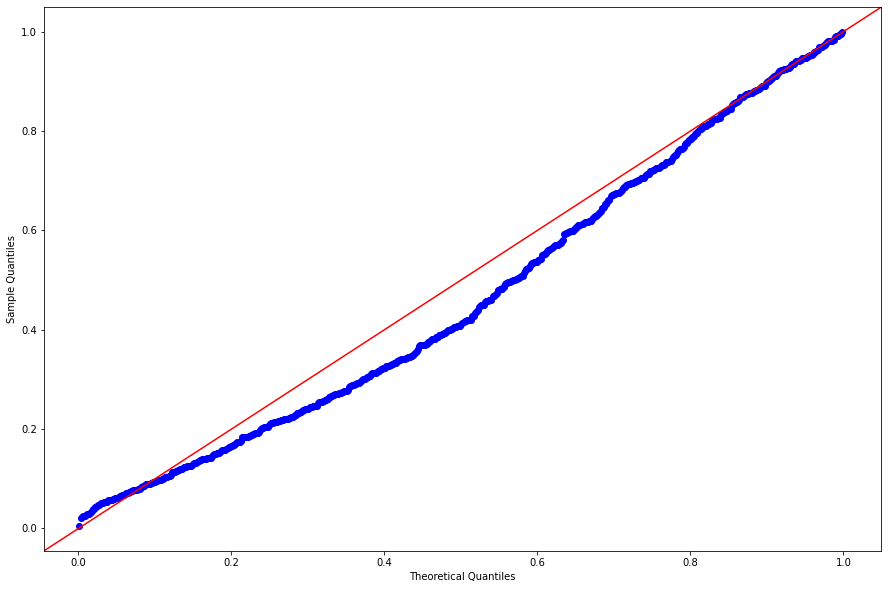

In [101]:
fig = sm.graphics.qqplot(np.array(values), dist=stats.uniform, line="45")

In [102]:
model_vol = pd.Series(np.mean(model1_data.posterior.h.values.reshape(10000, -1), axis=0), index=y.index)
model_vol = np.sqrt(np.exp(model_vol))

<AxesSubplot:>

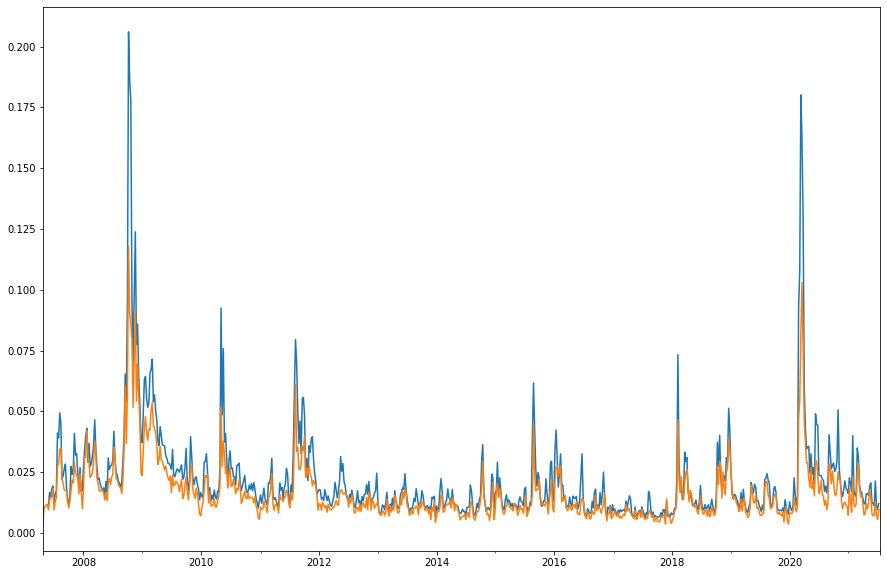

In [103]:
model_vol.plot()
np.sqrt(spx_wk_vol).plot()

# Model 2

In [105]:
model_spec = """
    data {
        int N;                              // Length of data
        vector[N] r;                        // SPX returns
    }
    parameters {
        real mu_h;                          // Volatility mean term
        real mu_r;                          // Returns mean term
        real<lower=-1, upper=1> phi;        // Persistence of volatility
        real<lower=0> sigma;                // Volatility noise
        vector[N] h_std;                    // Log volatility
        real alpha;                         // Skew Normal shape parameter
    }
    transformed parameters {
        vector[N] h = h_std * sigma;        // h ~ normal(0, sigma);
        h[1] /= sqrt(1 - square(phi));      // h[1] ~ normal(0, sigma / sqrt(1 - square(phi)))
        h += mu_h;                          // h ~ normal(mu_h, sigma)
        for (t in 2:N) {
            h[t] += phi * (h[t-1] - mu_h);  // h[2:N] ~ normal(mu_h + phi * (h[t-1] - mu_h), sigma)
        }
    }
    model {
        phi ~ uniform(-1, 1);
        sigma ~ normal(0, 10);
        mu_h ~ normal(0, 10);
        mu_r ~ normal(0, 10);
        alpha ~ normal(0, 10);
        
        h_std ~ std_normal();
        r ~ skew_normal(mu_r, exp(h / 2), alpha);
    }
    generated quantities {
        real r_tilde[N];
        real log_prob[N];
        r_tilde = skew_normal_rng(mu_r, exp(h / 2), alpha);
        for (t in 1:N) {
            log_prob[t] = skew_normal_lpdf(r[t] | mu_r, exp(h[t] / 2), alpha);  // Need log probabilities later on
        }
    }
"""
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model


In [118]:
data = {"N": len(y), "r": y.values}
sample = model.sample(data=data,
                      chains=4,
                      parallel_chains=4,
                      output_dir="./stan_model",
                      iter_warmup=1000,
                      iter_sampling=2500)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


In [119]:
model2_data = az.from_cmdstanpy(posterior=sample,
                                posterior_predictive="r_tilde",
                                observed_data={"r": y.values},
                                log_likelihood="log_prob")

In [230]:
def plot_moment_checks(arviz_data):
    # Name of posterior predictive variable
    post_pred_name = list(arviz_data.posterior_predictive.keys())[0]
    post_pred = arviz_data.posterior_predictive.stack(sample=("draw", "chain"))[
        post_pred_name
    ].values
    mean = np.mean(post_pred, axis=0)
    std = np.std(post_pred, axis=0)
    skew = stats.skew(post_pred, axis=0)
    kurt = stats.kurtosis(post_pred, axis=0)

    # Name of observed data variable
    obs_data_name = list(arviz_data.observed_data.keys())[0]
    obs_data = arviz_data.observed_data[obs_data_name].values
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].hist(mean, bins=50)
    axs[0, 0].axvline(np.mean(obs_data), color="black")
    axs[0, 0].set_title("Mean")
    axs[0, 1].hist(std, bins=50)
    axs[0, 1].axvline(np.std(obs_data), color="black")
    axs[0, 1].set_title("Standard Deviation")
    axs[1, 0].hist(skew, bins=50)
    axs[1, 0].axvline(stats.skew(obs_data), color="black")
    axs[1, 0].set_title("Skew")
    axs[1, 1].hist(kurt, bins=50)
    axs[1, 1].axvline(stats.kurtosis(obs_data), color="black")
    axs[1, 1].set_title("Kurtosis")

    return fig